In [1]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# reading the dataset intp pandas dataframe
data = pd.read_csv('laptop_data_M.csv',index_col=0)

# About Data

In [3]:
data.head()

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [4]:
data.shape

(1303, 11)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


# processing the screen resolution

In [6]:
#getting all the unique values
data['ScreenResolution'].unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Retina Display 2304x1440',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800',
       'IPS Panel Touchscreen 1920x1200', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       'IPS Panel Full HD 2160x1440',
       '4K Ultra HD / Touchscreen 3840x2160', 'Touchscreen 2560x1440',
       '1600x900', 'IPS Panel 4K Ultra HD 3840x2160',
       '4K Ultra HD 3840x2160', 'Touchscreen 1366x768',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel 

In [7]:
# function to parse screen resolution and extract details
def parse_screen_resolution(resolution):

    resolution_match = re.search(r'(\d+x\d+)', resolution)
    if resolution_match:
        width, height = map(int, resolution_match.group(0).split('x'))
        pixels = width * height
    else:
        width, height, pixels = np.nan, np.nan, np.nan

    features = re.sub(r'(\d+x\d+)', '', resolution).split('/')
    features = [feature.strip() for feature in features if feature.strip() != '']
    if not features:
        features.append('Standard')
    
    return width, height, pixels, features

# Apply the function to each row in the ScreenResolution column
parsed_data = data['ScreenResolution'].apply(parse_screen_resolution)

# Create new columns for resolution details and features
data[['ScreenWidth', 'ScreenHeight', 'TotalPixels', 'Features']] = pd.DataFrame(parsed_data.tolist(), index=data.index)

# One-Hot Encoding of features
mlb = MultiLabelBinarizer()
features_encoded = mlb.fit_transform(data['Features'])
features_df = pd.DataFrame(features_encoded, columns=mlb.classes_, index=data.index)


# Concatenate the original DataFrame with the new features DataFrame
data = pd.concat([data, features_df], axis=1)

# Pre processing type name

In [8]:
# add one-hot encoding on the 'TypeName' column
type_name_encoded = pd.get_dummies(data['TypeName'], prefix='Type')
data = data.join(type_name_encoded)

# pre processing cpu

In [9]:
# To extract CPU brand from CPU column
def extract_cpu_brand(cpu):
    if 'Intel' in cpu:
        return 'Intel'
    elif 'AMD' in cpu:
        return 'AMD'
    elif 'Samsung' in cpu:
        return 'Samsung'
    else:
        return 'Other'

data['CpuBrand'] = data['Cpu'].apply(extract_cpu_brand)

In [10]:
# extract CPU clock speed(GHz) from CPU column
def extract_cpu_ghz(cpu):
    ghz_search = re.search(r'(\d+(\.\d+)?)GHz', cpu)
    if ghz_search:
        return float(ghz_search.group(1))
    else:
        return None

# Apply the function to the 'Cpu' column to create a new 'CpuGHz' column
data['CpuGHz'] = data['Cpu'].apply(extract_cpu_ghz)

In [11]:
data[['Cpu', 'CpuGHz']].head()

,Cpu,CpuGHz
0,Intel Core i5 2.3GHz,2.3
1,Intel Core i5 1.8GHz,1.8
2,Intel Core i5 7200U 2.5GHz,2.5
3,Intel Core i7 2.7GHz,2.7
4,Intel Core i5 3.1GHz,3.1


# pre processing RAM

In [12]:
# Getting all the unique values
data['Ram'].unique()

array(['8GB', '16GB', '4GB', '2GB', '12GB', '6GB', '32GB', '24GB', '64GB'],
      dtype=object)

In [13]:
# converting all RAM to float from object
data['Ram'] = data['Ram'].str.replace('GB', '').astype('float64')

# preprocessing memory 

In [14]:
data['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '32GB Flash Storage', '128GB SSD +  1TB HDD',
       '256GB SSD +  256GB SSD', '64GB Flash Storage',
       '256GB SSD +  1TB HDD', '256GB SSD +  2TB HDD', '32GB SSD',
       '2TB HDD', '64GB SSD', '1.0TB Hybrid', '512GB SSD +  1TB HDD',
       '1TB SSD', '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '512GB Flash Storage',
       '128GB HDD', '240GB SSD', '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [15]:
memory_data = data['Memory']

# To convert all memory sizes to GB
def convert_to_gb(size):
    if 'TB' in size:
        return str(int(size.replace('TB', '')) * 1024) + 'GB'
    return size

# Parse memory data to extract details and  Replace 'TB' with equivalent 'GB' for uniformity
def parse_memory(memory_str):
    memory_str = re.sub(r'(\d)TB', lambda x: f"{int(x.group(1)) * 1024}GB", memory_str)
    memory_parts = re.findall(r'(\d+GB) (\w+)', memory_str)
    
    total_memory = 0
    memory_types = set()
    for part in memory_parts:
        # Sum up capacities
        capacity, type = part
        capacity_gb = int(capacity.replace('GB', ''))
        total_memory += capacity_gb
        # Identify memory types
        memory_types.add(type)
    
    return total_memory, memory_types

parsed_memory = memory_data.apply(parse_memory)

# Create separate columns for total capacity and memory types
data['TotalMemory_GB'] = parsed_memory.apply(lambda x: x[0])
memory_types_series = parsed_memory.apply(lambda x: x[1])

# One-hot encode the memory types
mlb = MultiLabelBinarizer()
memory_types_encoded = mlb.fit_transform(memory_types_series)
memory_types_df = pd.DataFrame(memory_types_encoded, columns=mlb.classes_, index=memory_data.index)

# Drop the original 'ScreenResolution' and 'Features' columns
data = data.drop(['Features'], axis=1)

# Concatenate the one-hot encoded memory types back to the original DataFrame
data = pd.concat([data, memory_types_df], axis=1)

# Example of how the DataFrame looks now
data[['Memory', 'TotalMemory_GB'] + list(mlb.classes_)].head()


,Memory,TotalMemory_GB,Flash,HDD,Hybrid,SSD
0,128GB SSD,128,0,0,0,1
1,128GB Flash Storage,128,1,0,0,0
2,256GB SSD,256,0,0,0,1
3,512GB SSD,512,0,0,0,1
4,256GB SSD,256,0,0,0,1


# GPU pre processing

In [16]:
# extract GPU brand from the GPU column
def extract_gpu_brand(gpu):
    if 'Intel' in gpu:
        return 'Intel'
    elif 'AMD' in gpu or 'Radeon' in gpu or 'FirePro' in gpu:
        return 'AMD'
    elif 'Nvidia' in gpu or 'GeForce' in gpu or 'Quadro' in gpu:
        return 'Nvidia'
    elif 'ARM' in gpu:
        return 'ARM'
    else:
        return 'Other'

data['GpuBrand'] = data['Gpu'].apply(extract_gpu_brand)

In [17]:
data['GpuBrand']

0       Intel
1       Intel
2       Intel
3         AMD
4       Intel
        ...  
1298    Intel
1299    Intel
1300    Intel
1301      AMD
1302    Intel
Name: GpuBrand, Length: 1303, dtype: object

# pre processing operating system

In [18]:
data['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

In [19]:
# To classify the operating system (OS) into categories
def classify_OS(OpSys):
    if 'macOS' in OpSys or 'Mac OS' in OpSys:
        return 'macOS'
    elif 'Windows' in OpSys:
        return 'Windows'
    elif 'No OS' in OpSys:
        return 'No OS'
    elif 'Linux' in OpSys:
        return 'Linux'
    elif 'Android' in OpSys:
        return 'Android'
    elif 'Chrome OS' in OpSys:
        return 'Chrome OS'
    else:
        return 'Other'

# Apply the function to the 'OpSys' column to create a new 'OS_Category' column
data['OS_Category'] = data['OpSys'].apply(classify_OS)


In [20]:
data['OS_Category'].unique()

array(['macOS', 'No OS', 'Windows', 'Linux', 'Android', 'Chrome OS'],
      dtype=object)

# preprocessing weight

In [21]:
# remove KG from the weight and convert to float value
data['Weight'] = data['Weight'].str.replace('kg', '').astype('float64')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303 entries, 0 to 1302
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Company                   1303 non-null   object 
 1   TypeName                  1303 non-null   object 
 2   Inches                    1303 non-null   float64
 3   ScreenResolution          1303 non-null   object 
 4   Cpu                       1303 non-null   object 
 5   Ram                       1303 non-null   float64
 6   Memory                    1303 non-null   object 
 7   Gpu                       1303 non-null   object 
 8   OpSys                     1303 non-null   object 
 9   Weight                    1303 non-null   float64
 10  Price                     1303 non-null   float64
 11  ScreenWidth               1303 non-null   int64  
 12  ScreenHeight              1303 non-null   int64  
 13  TotalPixels               1303 non-null   int64  
 14  4K Ultra

<Axes: >

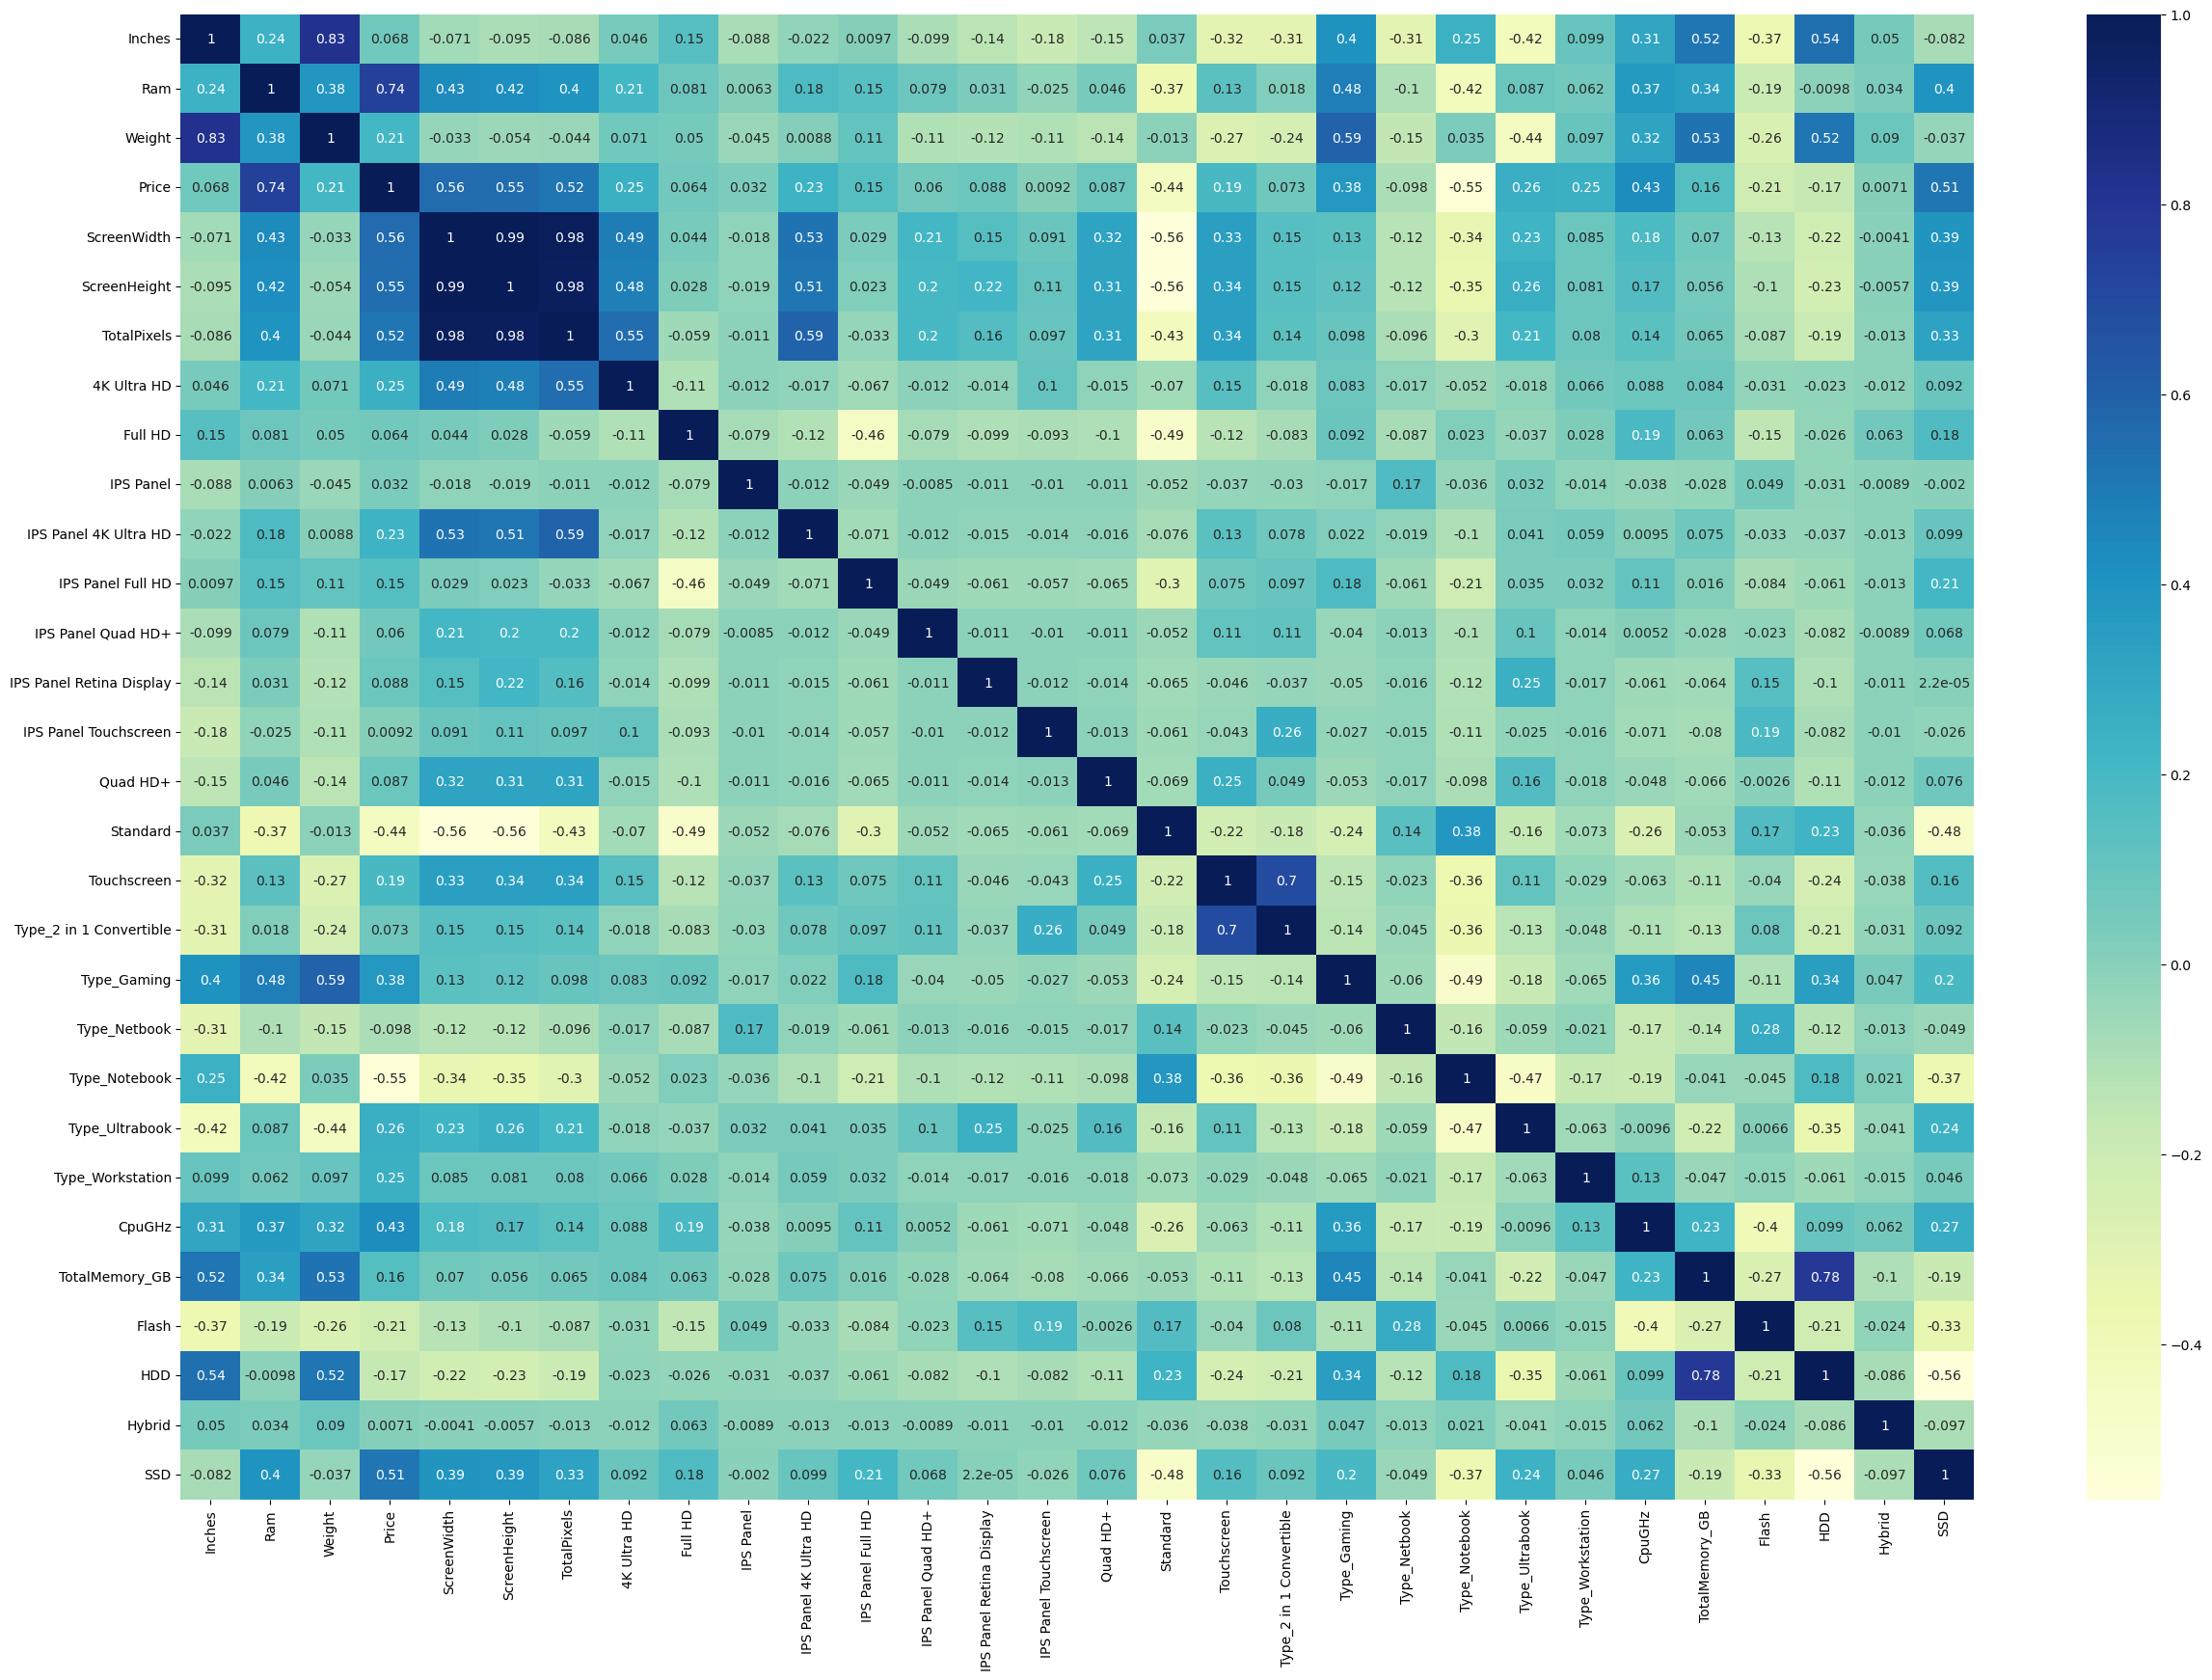

In [23]:
#Plot a heatmap of the correlation matrix for numerical columns in the DataFrame
plt.figure(figsize=(30,20))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="YlGnBu")

In [24]:
data.shape

(1303, 40)

# Data Visulalization

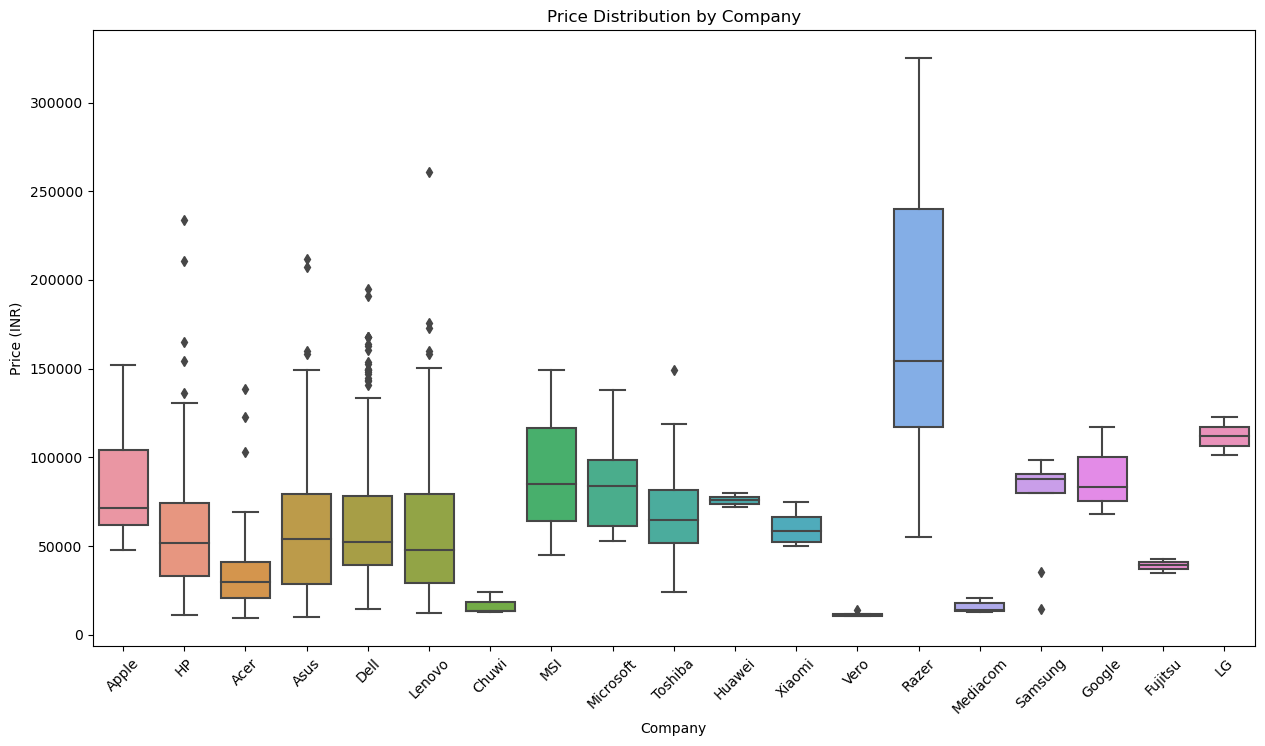

In [25]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Company', y='Price', data=data)
plt.title('Price Distribution by Company')
plt.xlabel('Company')
plt.ylabel('Price (INR)') 

plt.xticks(rotation=45)

plt.show()


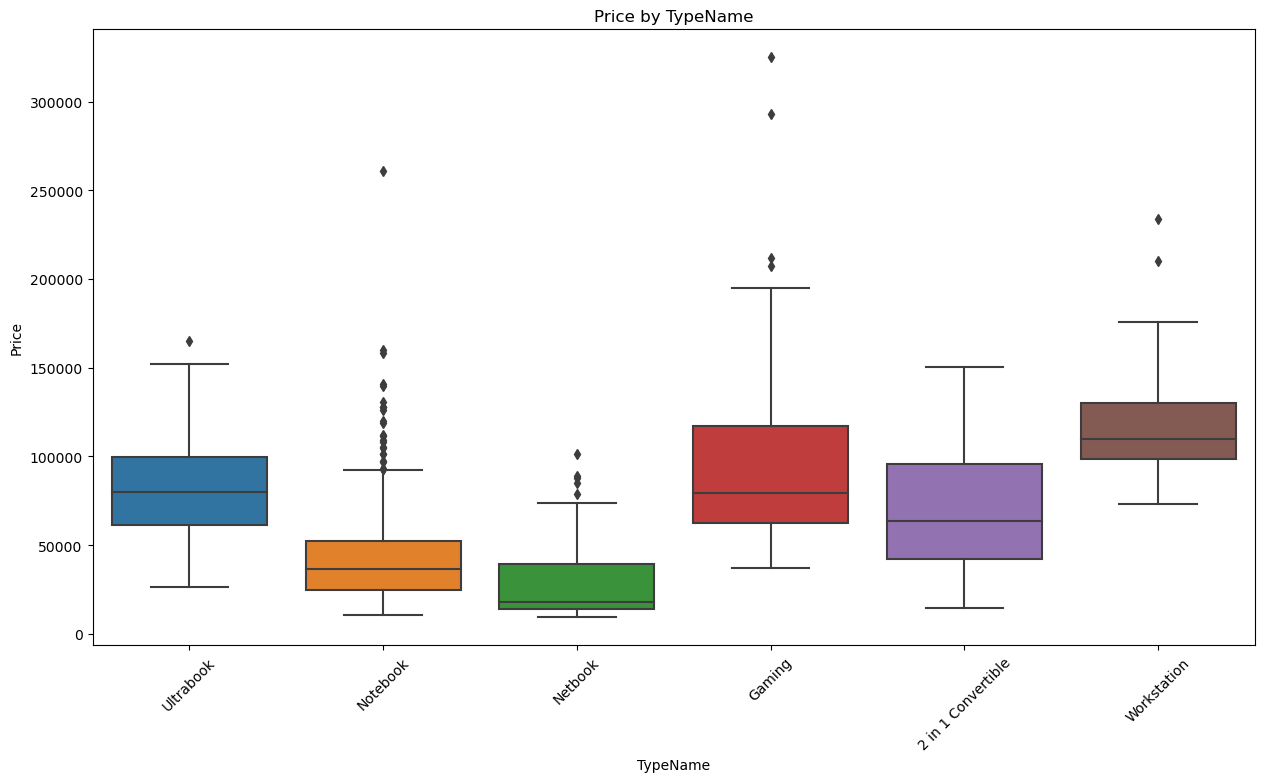

In [26]:
plt.figure(figsize=(15,8))
sns.boxplot(x='TypeName', y='Price', data=data)
plt.title('Price by TypeName')
plt.xlabel('TypeName')
plt.ylabel('Price')

plt.xticks(rotation=45)

plt.show()


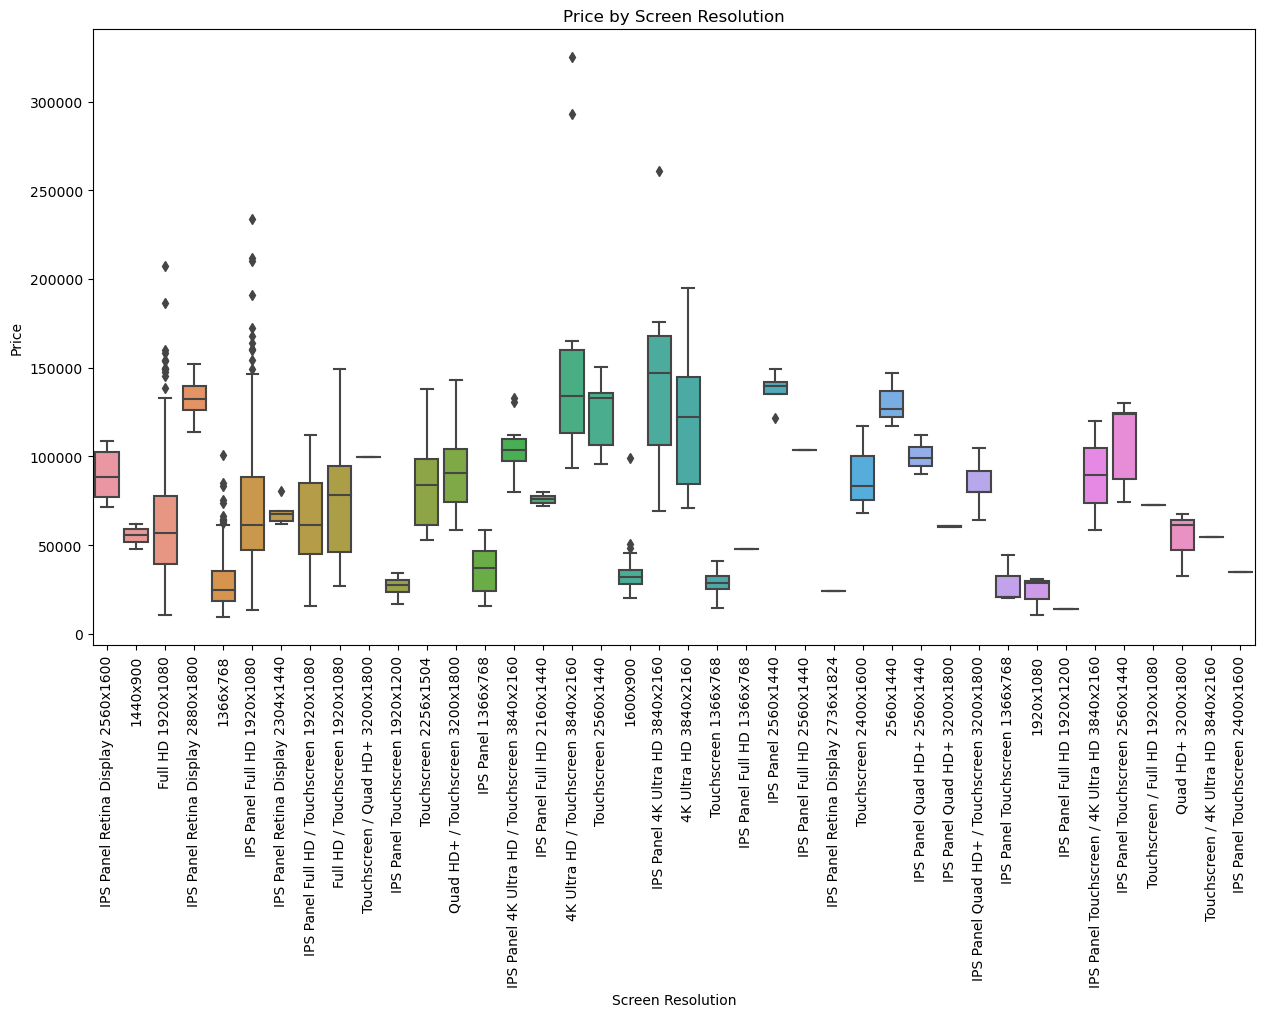

In [27]:
plt.figure(figsize=(15,8))
sns.boxplot(x='ScreenResolution', y='Price', data=data)
plt.title('Price by Screen Resolution')
plt.xlabel('Screen Resolution')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()

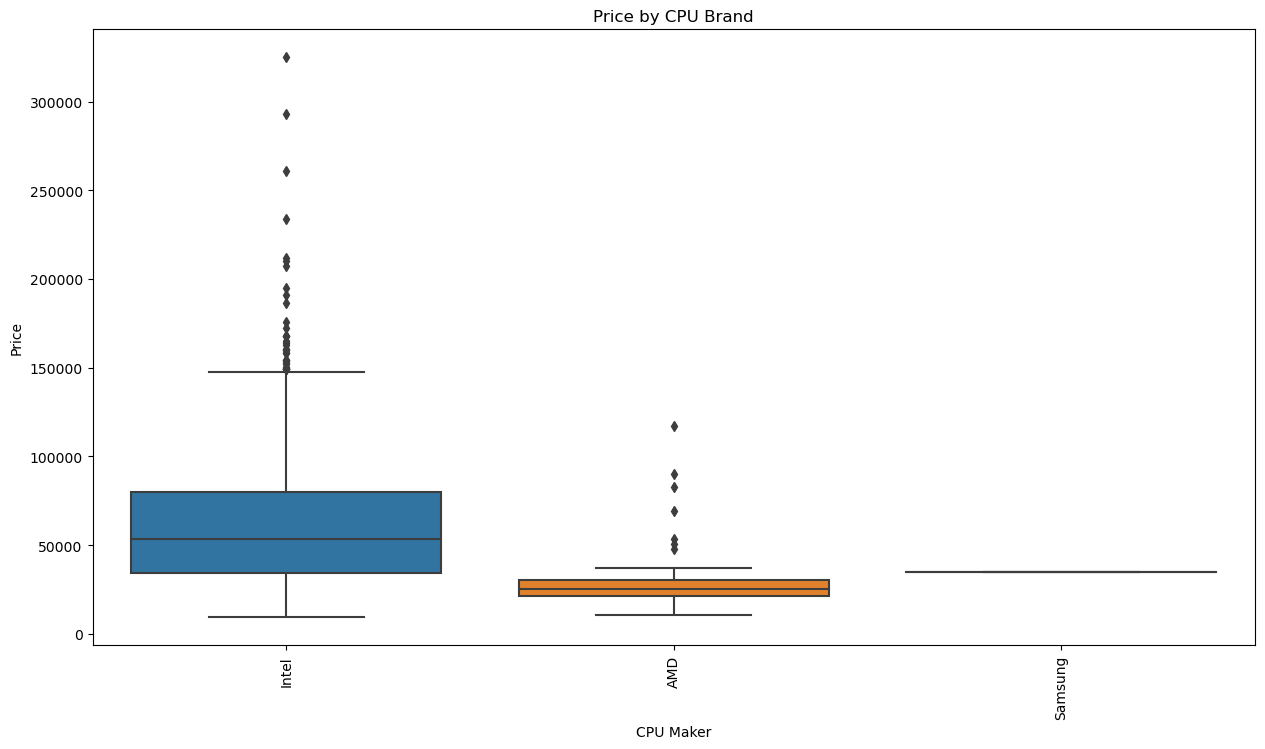

In [28]:
plt.figure(figsize=(15,8))
sns.boxplot(x='CpuBrand', y='Price', data=data)
plt.title('Price by CPU Brand')
plt.xlabel('CPU Maker')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


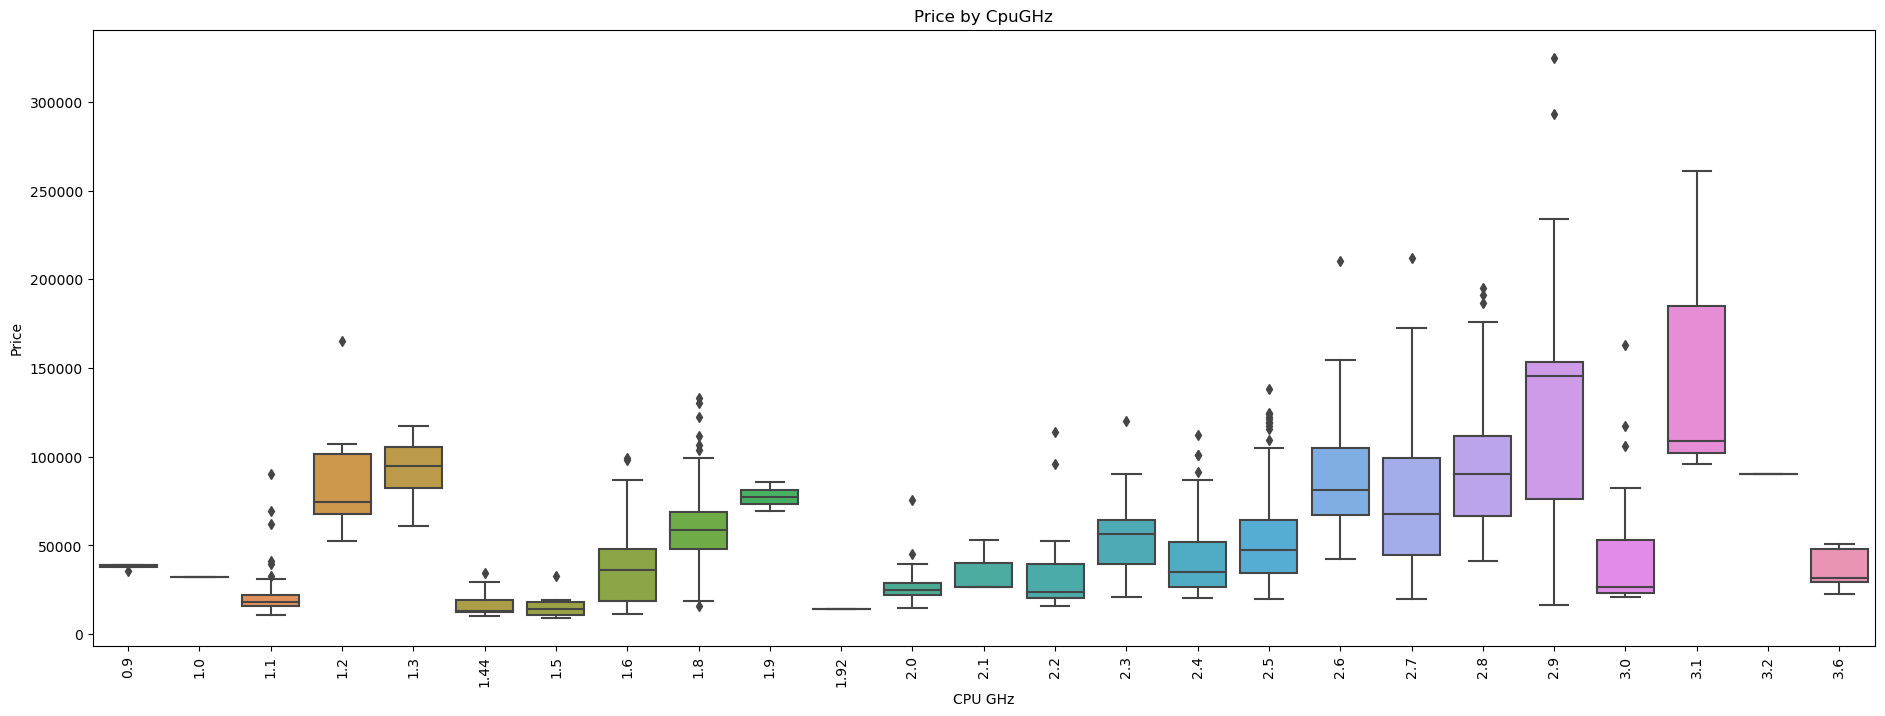

In [29]:
plt.figure(figsize=(23,8))
sns.boxplot(x='CpuGHz', y='Price', data=data)
plt.title('Price by CpuGHz')
plt.xlabel('CPU GHz')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


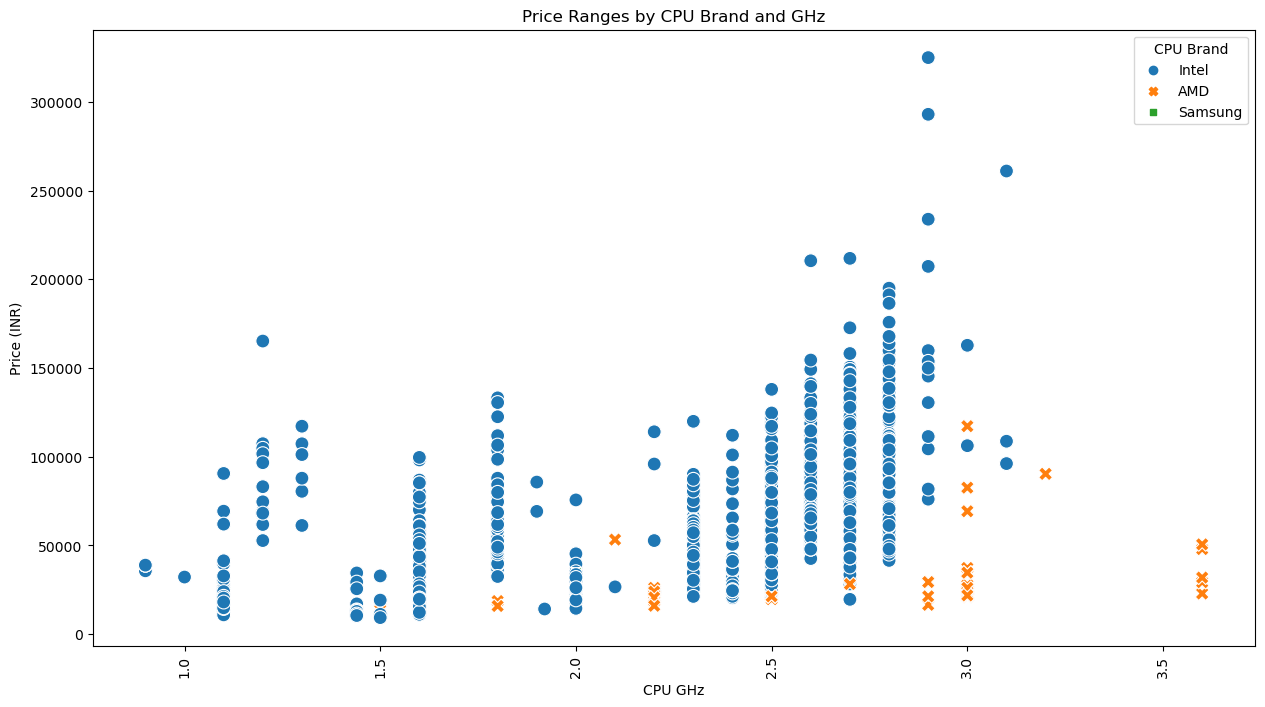

In [30]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=data, x='CpuGHz', y='Price', hue='CpuBrand', style='CpuBrand', s=100)
plt.title('Price Ranges by CPU Brand and GHz')
plt.xlabel('CPU GHz')
plt.ylabel('Price (INR)')
plt.legend(title='CPU Brand')
plt.xticks(rotation=90)
plt.show()

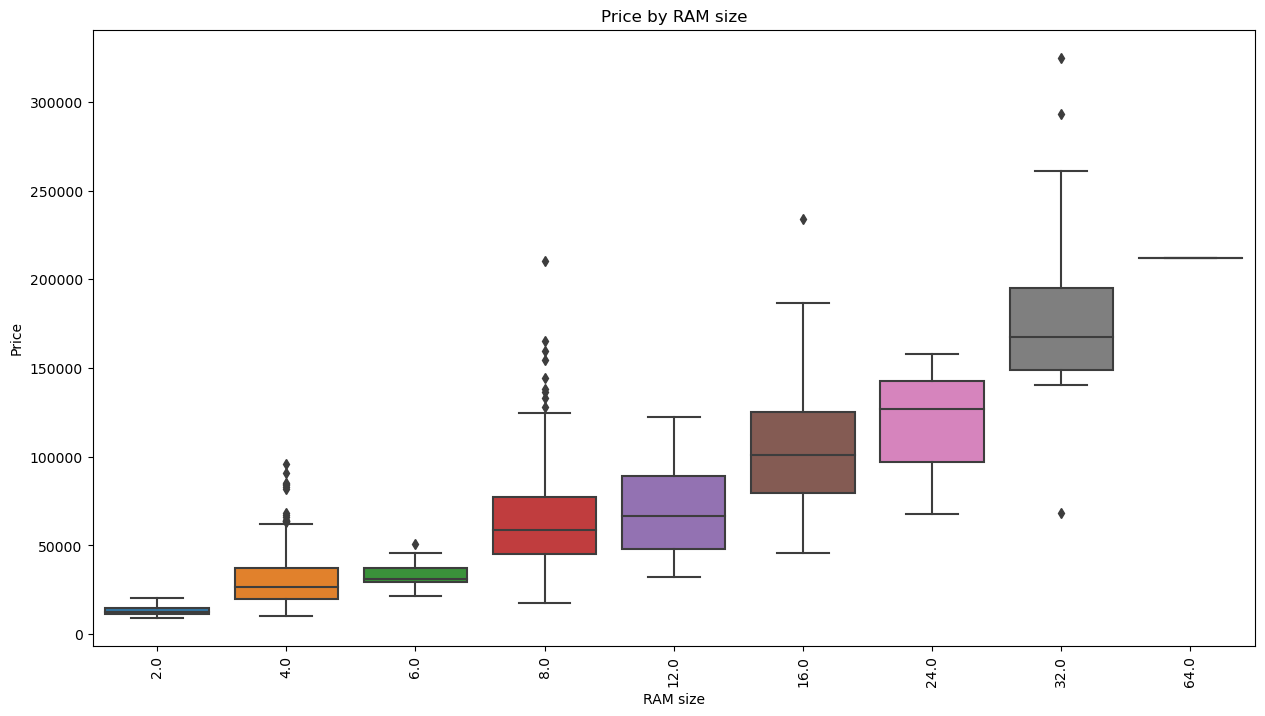

In [31]:
plt.figure(figsize=(15,8))
sns.boxplot(x='Ram', y='Price', data=data)
plt.title('Price by RAM size')
plt.xlabel('RAM size')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


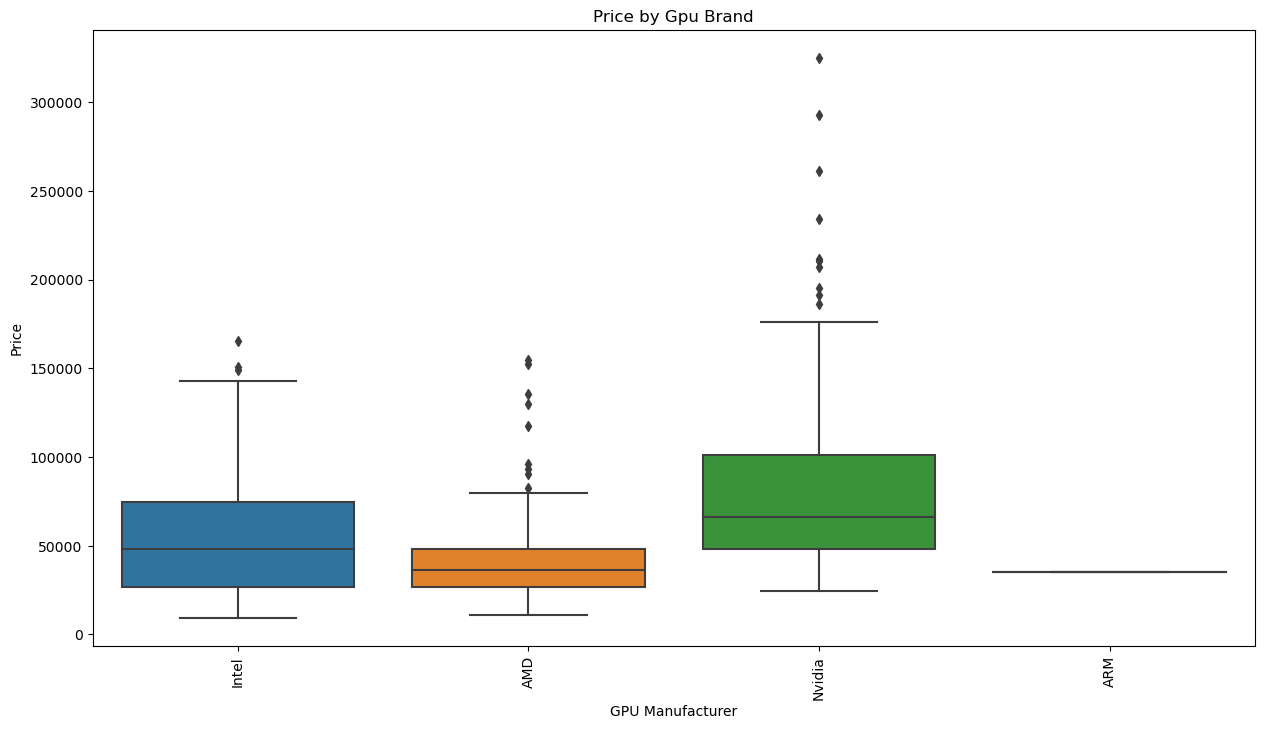

In [32]:
plt.figure(figsize=(15,8))
sns.boxplot(x='GpuBrand', y='Price', data=data)
plt.title('Price by Gpu Brand')
plt.xlabel('GPU Manufacturer')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


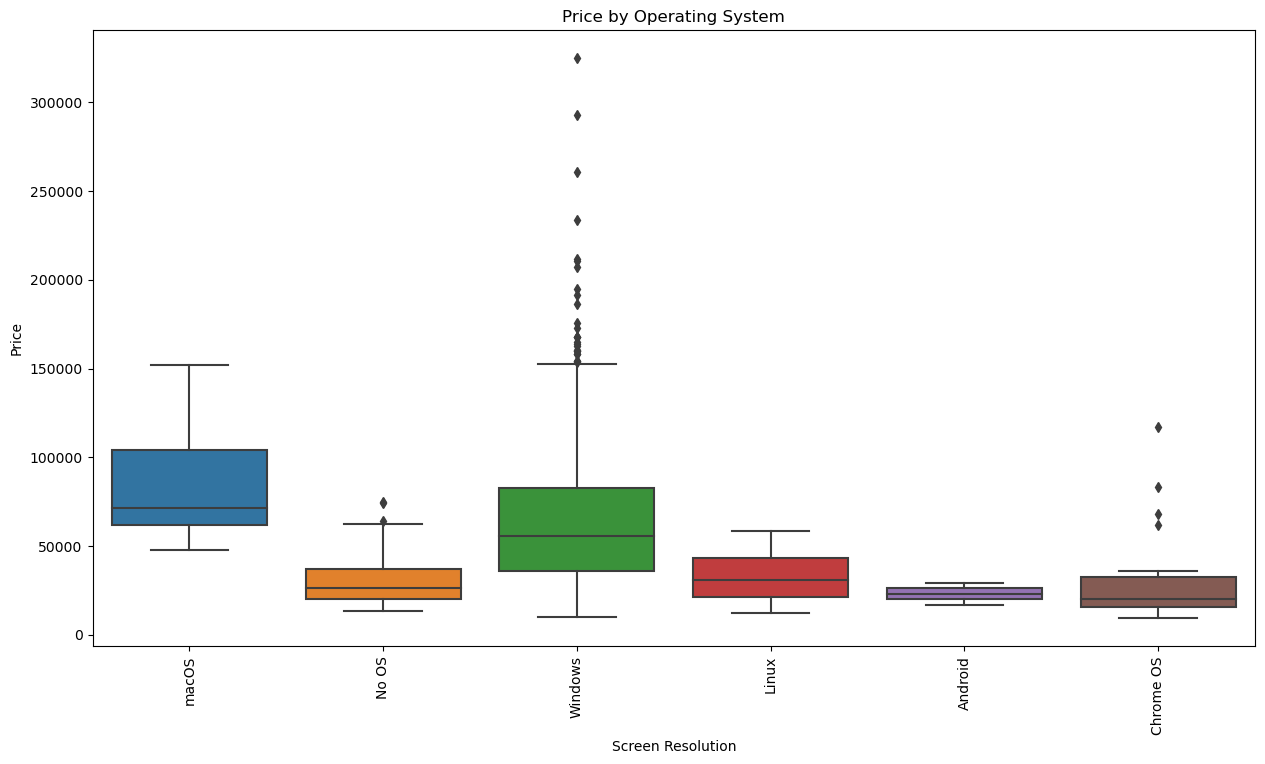

In [33]:
plt.figure(figsize=(15,8))
sns.boxplot(x='OS_Category', y='Price', data=data)
plt.title('Price by Operating System')
plt.xlabel('Screen Resolution')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.show()


# Feature engineering

In [34]:
# function to score RAM based on its size
def ram_score(ram):
    if ram <= 2:
        return 1
    elif ram <= 4:
        return 2
    elif ram <= 6:
        return 3
    elif ram <= 8:
        return 4
    elif ram <= 12:
        return 5
    elif ram <= 16:
        return 6
    elif ram <= 24:
        return 7
    elif ram <= 32:
        return 8
    elif ram <= 64:
        return 9
    else:
        return 10
# function to score storage based on its type
def storage_score(storage):
    if 'SSD' in storage:
        return 3
    elif 'HDD' in storage:
        return 1
    elif 'Hybrid' in storage or 'Flash' in storage:
        return 2
    return 0 
# function to score CPU clock speed GHz
def cpu_ghz_score(ghz):
    if ghz < 1:
        return 1
    elif ghz < 1.5:
        return 2
    elif ghz < 2:
        return 3
    elif ghz < 2.5:
        return 4
    elif ghz < 3:
        return 5
    else:
        return 6
# function to score screen specifications
def screen_score(row):
    score = 0
    if row['Full HD']:
        score += 2
    elif row['Quad HD+']:
        score += 3
    elif row['4K Ultra HD']:
        score += 4
    else:
        score += 1  # Default for standard resolution
    
    if row['IPS Panel']:
        score += 1  # Additional score for IPS panel
    
    if row['Touchscreen']:
        score += 1  # Additional score for touchscreen
    
    return score
# function to score GPU based on its brand and model
def gpu_score(gpu):
    if 'Intel' in gpu or 'ARM' in gpu:
        return 1  # Integrated GPUs
    elif 'Nvidia MX' in gpu or 'AMD Radeon R5' in gpu or 'Nvidia GT' in gpu:
        return 2  # Entry-level dedicated GPUs
    elif 'Nvidia GTX 1050' in gpu or 'Nvidia GTX 960' in gpu or 'AMD Radeon RX' in gpu:
        return 3  # Mid-range dedicated GPUs
    elif 'Nvidia GTX 106' in gpu or 'AMD Radeon RX 58' in gpu or 'Nvidia Quadro' in gpu or 'AMD FirePro' in gpu:
        return 4  # High-end dedicated GPUs
    else:
        return 2  # Default to entry-level if the GPU does not fit into known categories

# function to calculate total performance score for each laptop
def calculate_total_score(row):
    total_score = 0
    total_score += ram_score(row['Ram'])
    total_score += storage_score(row['Memory'])
    total_score += cpu_ghz_score(row['CpuGHz'])
    total_score += screen_score(row)
    total_score += gpu_score(row['Gpu'])
    return total_score

# Calculate the performance score for each laptop
data['PerformanceScore'] = data.apply(calculate_total_score, axis=1)


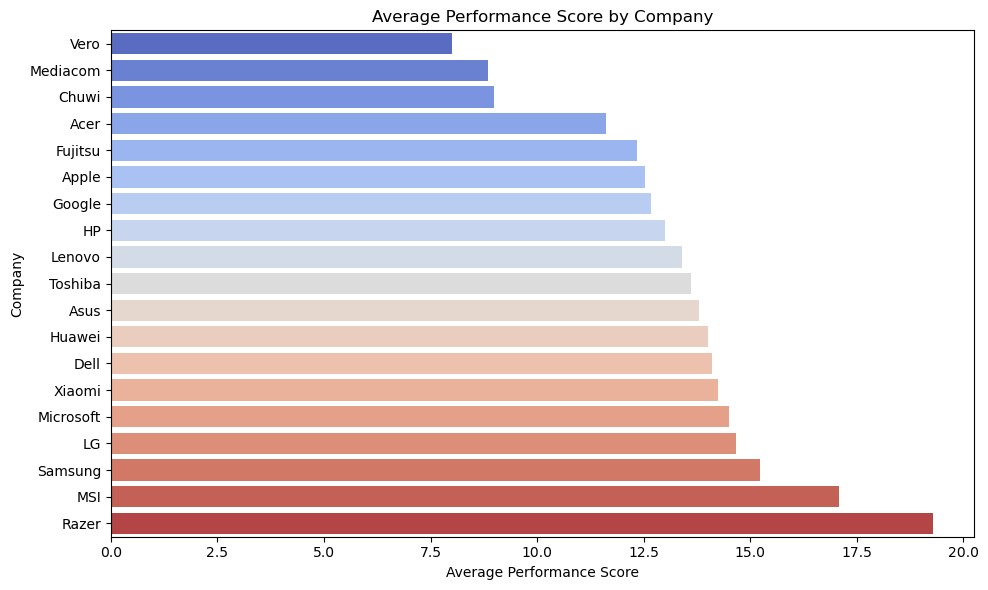

In [35]:
# Calculate mean performance score for each company
company_performance = data.groupby('Company')['PerformanceScore'].mean().sort_values()
plt.figure(figsize=(10, 6))
sns.barplot(x=company_performance.values, y=company_performance.index, palette='coolwarm')
plt.title('Average Performance Score by Company')
plt.xlabel('Average Performance Score')
plt.ylabel('Company')
plt.tight_layout()
plt.show()

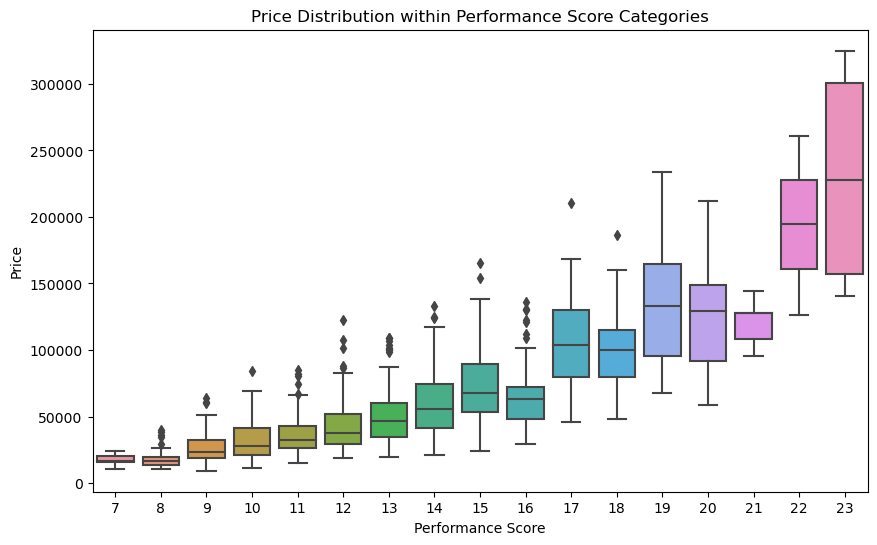

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='PerformanceScore', y='Price', data=data)
plt.title('Price Distribution within Performance Score Categories')
plt.xlabel('Performance Score')
plt.ylabel('Price')
plt.show()

In [37]:
# for testing
Wdata = data.drop(['TypeName', 'ScreenResolution', 'GpuBrand', 'OS_Category', 'CpuBrand', 'Cpu', 'ScreenWidth', 'ScreenHeight', 'Memory'], axis=1)

# Machine Learning

In [38]:
# Separate features (X) and target variable (y)
X = data.drop('Price', axis=1)
y = data['Price']

# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'int32']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Creating the preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [39]:
# Creating a pipeline for linear regression
lin_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', LinearRegression())])

# Training the model
lin_reg_pipeline.fit(X_train, y_train)

# Making predictions
y_pred_lin_reg = lin_reg_pipeline.predict(X_test)

In [40]:
# Creating a pipeline for random forest regressor
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
# Training the model
rf_pipeline.fit(X_train, y_train)

# Making predictions
y_pred_rf = rf_pipeline.predict(X_test)

In [41]:
# R^2 score and Mean Squared Error (MSE) for the models
print('Linear Regression R^2:', r2_score(y_test, y_pred_lin_reg))
print('Linear Regression MSE:', mean_squared_error(y_test, y_pred_lin_reg))
print('Random Forest R^2:', r2_score(y_test, y_pred_rf))
print('Random Forest MSE:', mean_squared_error(y_test, y_pred_rf))

Linear Regression R^2: 0.8539451289450724
Linear Regression MSE: 210593698.07428703
Random Forest R^2: 0.7969262480146501
Random Forest MSE: 292808121.3829025


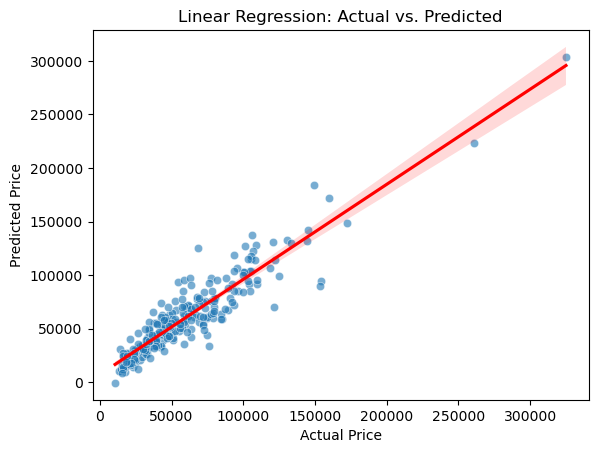

In [42]:
sns.scatterplot(x=y_test, y=y_pred_lin_reg, alpha=0.6)
sns.regplot(x=y_test, y=y_pred_lin_reg, scatter=False, color='red')
plt.title('Linear Regression: Actual vs. Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

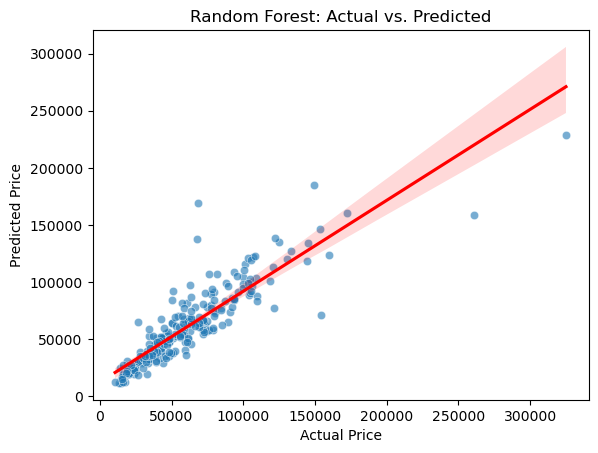

In [43]:
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.6)
sns.regplot(x=y_test, y=y_pred_rf, scatter=False, color='red')
plt.title('Random Forest: Actual vs. Predicted')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

# Dimensionality reduction testing

In [44]:
X = Wdata.drop('Price', axis=1)
y = Wdata['Price']

# Identifying numerical and categorical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64', 'int32']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Creating the preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Creating a pipeline for linear regression
lin_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', LinearRegression())])

# Training the model
lin_reg_pipeline.fit(X_train, y_train)

# Making predictions
y_pred_lin_reg = lin_reg_pipeline.predict(X_test)

# Evaluating the model
print('Linear Regression R^2:', r2_score(y_test, y_pred_lin_reg))
print('Linear Regression MSE:', mean_squared_error(y_test, y_pred_lin_reg))


Linear Regression R^2: 0.7975388858764474
Linear Regression MSE: 291924770.6807703


In [46]:
# Creating a pipeline for random forest regressor
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print('Random Forest R^2:', r2_score(y_test, y_pred_rf))
print('Random Forest MSE:', mean_squared_error(y_test, y_pred_rf))


Random Forest R^2: 0.7754648281900243
Random Forest MSE: 323752928.1815271
